In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import sklearn

1) 데이터 로드 및 분할하기

In [2]:
df = pd.read_csv("final_data.csv", index_col=0)
df.head()

,Sentence,Change
0,"주가 사흘째 상승세\n아남텔레콤, PDA 데이터 전송서비스 개시\n<회전목마> 삼성...",0
1,주가 3백70선 회복\n`반도체업체는 여전히 안정된 직장'\n휴대형 입체영상 모니터...,0
2,"삼성디자인연구원, 전통유산 디자인 CD-롬 제작\n주가 3백50대로 밀려\n<확대경...",1
3,"한도폐지 첫날 주가 하락세\n주가, 11년만에 최저치로 폭락\n",0
4,"주가 급락세 지속, 3백10선도 위협\n삼성전자, 매출 급신장\n엘니뇨 덕, 에어컨...",1


In [3]:
df_shuffled=sklearn.utils.shuffle(df)
df_shuffled.head()

,Sentence,Change
5373,[속보] 이재용 삼성전자 부회장 영장실질심사 출석\n[속보] 이재용 영장실질심사 출...,1
1365,"[유럽DR]삼성전자, 나홀로 상승\n[유럽DR-마감] 삼성전자만 상승\n소버린은 물...",0
2445,전기·가스요금 인상폭 낮아진다\n삼성전자 박수홍 책임연구원 W3C 미디어워킹그룹 의...,0
3298,"미래에셋證, ELS 9종 판매\n(투자클럽핫종목)S&T중공업·바이오스페이스·삼성SD...",1
1824,와이브로 주도권 확보 잰걸음\n“타도 삼성반도체” 연합전선 또 출범\n지난해 HTS...,0


In [4]:
train_ratio = 0.8
train_range = int(len(df_shuffled) * train_ratio)
train_range

4721

In [5]:
train_data = df_shuffled[:train_range]
test_data = df_shuffled[train_range:]

print(len(train_data), len(test_data))

4721 1181


2) 데이터 정제하기

In [6]:
'''
document 열의 중복 제거 (Sentence와 label로만 구성)
'''
train_data.drop_duplicates(subset=['Sentence'], inplace=True)

/var/folders/dw/h996rvzd3dgfxkgv5h6l_qcm0000gn/T/ipykernel_40964/2722717654.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop_duplicates(subset=['Sentence'], inplace=True)


<AxesSubplot:>

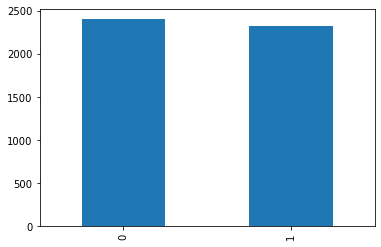

In [9]:
'''
Label값 분포 확인
'''
train_data['Change'].value_counts().plot(kind = 'bar')

In [11]:
'''
Null이 있나 확인 후 있으면 제거
'''
print(train_data.isnull().values.any())
print(train_data.isnull().sum())
train_data.loc[train_data.Sentence.isnull()]
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False
Sentence    0
Change      0
dtype: int64
False


In [12]:
'''
한글과 공백을 제외하고 모두 제거
'''
train_data['Sentence'] = train_data['Sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

/var/folders/dw/h996rvzd3dgfxkgv5h6l_qcm0000gn/T/ipykernel_40964/3744129366.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['Sentence'] = train_data['Sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,Sentence,Change
5373,속보 이재용 삼성전자 부회장 영장실질심사 출석속보 이재용 영장실질심사 출석밤늦게 구...,1
1365,유럽삼성전자 나홀로 상승유럽마감 삼성전자만 상승소버린은 물러서지 않으리 수능 강의 ...,0
2445,전기가스요금 인상폭 낮아진다삼성전자 박수홍 책임연구원 미디어워킹그룹 의장에이봉주 ...,0
3298,미래에셋 종 판매투자클럽핫종목중공업바이오스페이스삼성 등김정일 사망 한국 신용위험 ...,1
1824,와이브로 주도권 확보 잰걸음타도 삼성반도체 연합전선 또 출범지난해 거래비중 증가개...,0


In [13]:
'''
한글이 아닌 리뷰는 empty가 됐을 것으므로, 이를 Null로 변경
'''
train_data['Sentence'] = train_data['Sentence'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['Sentence'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

/var/folders/dw/h996rvzd3dgfxkgv5h6l_qcm0000gn/T/ipykernel_40964/4220149124.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['Sentence'] = train_data['Sentence'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


Sentence    0
Change      0
dtype: int64


In [14]:
train_data.loc[train_data.Sentence.isnull()] # Null 있는 행 출력 

,Sentence,Change


In [15]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

4721


In [16]:
'''
테스트 데이터도 동일하게 전처리 진행
'''

test_data.drop_duplicates(subset = ['Sentence'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['Sentence'] = test_data['Sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['Sentence'] = test_data['Sentence'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['Sentence'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

/var/folders/dw/h996rvzd3dgfxkgv5h6l_qcm0000gn/T/ipykernel_40964/3788361190.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop_duplicates(subset = ['Sentence'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
/var/folders/dw/h996rvzd3dgfxkgv5h6l_qcm0000gn/T/ipykernel_40964/3788361190.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['Sentence'] = test_data['Sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


전처리 후 테스트용 샘플의 개수 : 1181


/var/folders/dw/h996rvzd3dgfxkgv5h6l_qcm0000gn/T/ipykernel_40964/3788361190.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Sentence'] = test_data['Sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
/var/folders/dw/h996rvzd3dgfxkgv5h6l_qcm0000gn/T/ipykernel_40964/3788361190.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['Sentence'] = test_data['Sentence'].str.replace('^ +', "") # 공백은 empty 값으로 변경
/var/folders/dw/h996rvzd3dgfxkgv5h6l_qcm0000gn/T/ipykernel_40964/3788361190.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

3) 토큰화

In [17]:
'''
Okt는 위와 같이 KoNLPy에서 제공하는 형태소 분석기임
한국어을 토큰화할 때는 영어처럼 띄어쓰기 기준으로 토큰화를 하는 것이 아니라, 주로 형태소 분석기를 사용함
stem = True를 사용하면 일정 수준의 정규화를 수행해주는데, 예를 들어 '이런'이 '이렇다'로 변환되고, '만드는'이 '만들다'로 변환됨
'''
okt = Okt()

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

X_train = []
for sentence in tqdm(train_data['Sentence']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 4721/4721 [31:58<00:00,  2.46it/s]  


In [ ]:
print(X_train[:3])

In [19]:
'''
테스트 데이터도 동일하게 토큰화 진행
'''
X_test = []
for sentence in tqdm(test_data['Sentence']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 1181/1181 [10:25<00:00,  1.89it/s]


4) 정수 인코딩

In [20]:
'''
훈련데이터에 대해서 단어집합(vocaburary) 만들기
'''
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [21]:
print(tokenizer.word_index) # 각 단어에 고유한 정수 부여

{'삼성': 1, '전자': 2, '코스피': 3, '삼': 4, '성': 5, '갤럭시': 6, '이재용': 7, '일': 8, '로': 9, '시': 10, '반도체': 11, '출시': 12, '선': 13, '주': 14, '년': 15, '기업': 16, '성전': 17, '시장': 18, '서': 19, '위': 20, '투자': 21, '장': 22, '황': 23, '대': 24, '전': 25, '분기': 26, '마감': 27, '등': 28, '상승': 29, '조': 30, '노트': 31, '스마트폰': 32, '하락': 33, '외국인': 34, '실적': 35, '부회장': 36, '한국': 37, '순': 38, '기관': 39, '증권': 40, '만': 41, '월': 42, '원': 43, '종목': 44, '기': 45, '기술': 46, '애플': 47, '되다': 48, '중': 49, '공개': 50, '사': 51, '만원': 52, '보다': 53, '억': 54, '증시': 55, '세계': 56, '최고': 57, '사업': 58, '회장': 59, '세': 60, '국내': 61, '지': 62, '종합': 63, '제': 64, '만에': 65, '첫': 66, '판매': 67, '수': 68, '영업': 69, '폰': 70, '적': 71, '오늘': 72, '글로벌': 73, '최대': 74, '매수': 75, '그룹': 76, '사장': 77, '개다': 78, '포토': 79, '대다': 80, '스마트': 81, '형': 82, '을': 83, '매도': 84, '까지': 85, '화': 86, '회복': 87, '신': 88, '주가': 89, '코스닥': 90, '상': 91, '에서': 92, '없다': 93, '명': 94, '개': 95, '돌파': 96, '이건희': 97, '올해': 98, '공': 99, '고': 100, '경제': 101, '개최': 102, '산업': 103, '확

In [22]:
'''
등장 빈도수가 3회 미만인 단어 비중 확인
'''
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 83858
등장 빈도가 2번 이하인 희귀 단어의 수: 35743
단어 집합에서 희귀 단어의 비율: 42.62324405542703
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.2258122367270682


In [23]:
'''
전체 단어 개수 중 빈도수 2이하인 단어는 제거
'''
vocab_size = total_cnt - rare_cnt + 1 # 0번 패딩 토큰을 고려하여 + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 48116


In [24]:
'''
단어 집합 크기를 반영해서 다시 정수 배정
'''
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [25]:
y_train = np.array(train_data['Change'])
y_test = np.array(test_data['Change'])

5) 빈 샘플 제거

In [26]:
'''
전체 데이터에서 빈도수가 낮은 단어가 삭제되어, 빈도수가 낮은 단어만으로 구성된 샘플이 있으면
empty sample이 되므로 이를 제거해 주는 과정
'''

drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

4721
4721


/opt/homebrew/Caskroom/miniforge/base/envs/a29/lib/python3.8/site-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


6) 패딩

리뷰의 최대 길이 : 42711
리뷰의 평균 길이 : 4300.158229188732


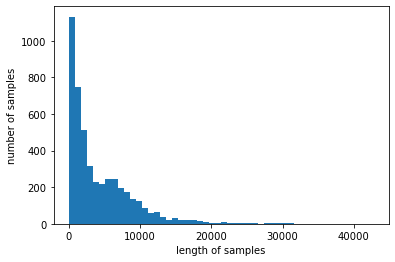

In [27]:
'''
서로 다른 샘플들의 길이를 동일하게 맞춰주는 작업
'''
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [28]:
'''
전체 샘플 중 길이가 max_len 이하인 샘플의 비율을 확인
'''
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [42]:
MAX_LEN = 30
below_threshold_len(MAX_LEN, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 100.0


In [30]:
'''
샘플의 길이를 MAX_LEN에 맞춤
'''
X_train = pad_sequences(X_train, maxlen=MAX_LEN)
X_test = pad_sequences(X_test, maxlen=MAX_LEN)

In [43]:
import tensorflow as tf

In [44]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim # d_model
        self.num_heads = num_heads

        assert embedding_dim % self.num_heads == 0

        self.projection_dim = embedding_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embedding_dim)
        self.key_dense = tf.keras.layers.Dense(embedding_dim)
        self.value_dense = tf.keras.layers.Dense(embedding_dim)
        self.dense = tf.keras.layers.Dense(embedding_dim)

    def scaled_dot_product_attention(self, query, key, value):
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output, attention_weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]

        # (batch_size, seq_len, embedding_dim)
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # (batch_size, num_heads, seq_len, projection_dim)
        query = self.split_heads(query, batch_size)  
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention, _ = self.scaled_dot_product_attention(query, key, value)
        # (batch_size, seq_len, num_heads, projection_dim)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

        # (batch_size, seq_len, embedding_dim)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embedding_dim))
        outputs = self.dense(concat_attention)
        return outputs

In [45]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(embedding_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(dff, activation="relu"),
             tf.keras.layers.Dense(embedding_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs) # 첫번째 서브층 : 멀티 헤드 어텐션
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output) # Add & Norm
        ffn_output = self.ffn(out1) # 두번째 서브층 : 포지션 와이즈 피드 포워드 신경망
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output) # Add & Norm

In [46]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, vocab_size, embedding_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.pos_emb = tf.keras.layers.Embedding(max_len, embedding_dim)

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [50]:
vocab_size = 20000  # 빈도수 상위 2만개의 단어만 사용
max_len = 30  # 문장의 최대 길이

print('훈련용 리뷰 개수 : {}'.format(len(X_train)))
print('테스트용 리뷰 개수 : {}'.format(len(X_test)))

훈련용 리뷰 개수 : 4721
테스트용 리뷰 개수 : 1181


In [51]:
embedding_dim = 32  # 각 단어의 임베딩 벡터의 차원
num_heads = 2  # 어텐션 헤드의 수
dff = 32  # 포지션 와이즈 피드 포워드 신경망의 은닉층의 크기

inputs = tf.keras.layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embedding_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embedding_dim, num_heads, dff)
x = transformer_block(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [52]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=32, epochs=2, validation_data=(X_test, y_test))

print("테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/2


InvalidArgumentError: Cannot assign a device for operation model_1/token_and_position_embedding_1/embedding_3/embedding_lookup: Could not satisfy explicit device specification '' because the node {{colocation_node model_1/token_and_position_embedding_1/embedding_3/embedding_lookup}} was colocated with a group of nodes that required incompatible device '/job:localhost/replica:0/task:0/device:GPU:0'. All available devices [/job:localhost/replica:0/task:0/device:CPU:0, /job:localhost/replica:0/task:0/device:GPU:0]. 
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=2 requested_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' assigned_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' resource_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' supported_device_types_=[CPU] possible_devices_=[]
AssignSubVariableOp: GPU CPU 
RealDiv: GPU CPU 
Sqrt: GPU CPU 
AssignVariableOp: GPU CPU 
UnsortedSegmentSum: GPU CPU 
Identity: GPU CPU 
StridedSlice: CPU 
Const: GPU CPU 
NoOp: GPU CPU 
Mul: GPU CPU 
Shape: GPU CPU 
_Arg: GPU CPU 
ResourceScatterAdd: GPU CPU 
Unique: GPU CPU 
ReadVariableOp: GPU CPU 
AddV2: GPU CPU 
ResourceGather: GPU CPU 

Colocation members, user-requested devices, and framework assigned devices, if any:
  model_1_token_and_position_embedding_1_embedding_3_embedding_lookup_2430 (_Arg)  framework assigned device=/job:localhost/replica:0/task:0/device:GPU:0
  adam_adam_update_1_readvariableop_resource (_Arg)  framework assigned device=/job:localhost/replica:0/task:0/device:GPU:0
  adam_adam_update_1_readvariableop_2_resource (_Arg)  framework assigned device=/job:localhost/replica:0/task:0/device:GPU:0
  model_1/token_and_position_embedding_1/embedding_3/embedding_lookup (ResourceGather) 
  model_1/token_and_position_embedding_1/embedding_3/embedding_lookup/Identity (Identity) 
  Adam/Adam/update_1/Unique (Unique) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update_1/Shape (Shape) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update_1/strided_slice/stack (Const) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update_1/strided_slice/stack_1 (Const) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update_1/strided_slice/stack_2 (Const) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update_1/strided_slice (StridedSlice) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update_1/UnsortedSegmentSum (UnsortedSegmentSum) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update_1/mul (Mul) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update_1/ReadVariableOp (ReadVariableOp) 
  Adam/Adam/update_1/mul_1 (Mul) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update_1/AssignVariableOp (AssignVariableOp) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update_1/ResourceScatterAdd (ResourceScatterAdd) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update_1/ReadVariableOp_1 (ReadVariableOp) 
  Adam/Adam/update_1/mul_2 (Mul) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update_1/mul_3 (Mul) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update_1/ReadVariableOp_2 (ReadVariableOp) 
  Adam/Adam/update_1/mul_4 (Mul) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update_1/AssignVariableOp_1 (AssignVariableOp) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update_1/ResourceScatterAdd_1 (ResourceScatterAdd) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update_1/ReadVariableOp_3 (ReadVariableOp) 
  Adam/Adam/update_1/Sqrt (Sqrt) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update_1/mul_5 (Mul) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update_1/add (AddV2) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update_1/truediv (RealDiv) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update_1/AssignSubVariableOp (AssignSubVariableOp) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update_1/group_deps/NoOp (NoOp) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update_1/group_deps/NoOp_1 (NoOp) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update_1/group_deps (NoOp) /job:localhost/replica:0/task:0/device:GPU:0

	 [[{{node model_1/token_and_position_embedding_1/embedding_3/embedding_lookup}}]] [Op:__inference_train_function_3377]